<a href="https://colab.research.google.com/github/xKDR/Julia-Workshop/blob/main/Statistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" /> _Colab Notebook Template_

## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. If you need a GPU: _Runtime_ > _Change runtime type_ > _Harware accelerator_ = _GPU_.
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2, 3 and 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Factory reset runtime_ and repeat steps 3 and 4.

In [1]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.10.4" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Unrecognized magic `%%shell`.

Julia does not use the IPython `%magic` syntax.   To interact with the IJulia kernel, use `IJulia.somefunction(...)`, for example.  Julia macros, string macros, and functions can be used to accomplish most of the other functionalities of IPython magics.


# Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system:

In [2]:
versioninfo()

Julia Version 1.10.4
Commit 48d4fd48430 (2024-06-04 10:41 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 2 × Intel(R) Xeon(R) CPU @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, broadwell)
Threads: 2 default, 0 interactive, 1 GC (on 2 virtual cores)
Environment:
  LD_LIBRARY_PATH = /usr/local/nvidia/lib:/usr/local/nvidia/lib64
  JULIA_NUM_THREADS = 2


In [3]:
using BenchmarkTools

M = rand(2^11, 2^11)

@btime $M * $M;

  571.981 ms (2 allocations: 32.00 MiB)


In [4]:
try
    using CUDA
catch
    println("No GPU found.")
else
    run(`nvidia-smi`)
    # Create a new random matrix directly on the GPU:
    M_on_gpu = CUDA.CURAND.rand(2^11, 2^11)
    @btime $M_on_gpu * $M_on_gpu; nothing
end

No GPU found.


# Need Help?

* Learning: https://julialang.org/learning/
* Documentation: https://docs.julialang.org/
* Questions & Discussions:
  * https://discourse.julialang.org/
  * http://julialang.slack.com/
  * https://stackoverflow.com/questions/tagged/julia

If you ever ask for help or file an issue about Julia, you should generally provide the output of `versioninfo()`.

Add new code cells by clicking the `+ Code` button (or _Insert_ > _Code cell_).

Have fun!

<img src="https://raw.githubusercontent.com/JuliaLang/julia-logo-graphics/master/images/julia-logo-mask.png" height="100" />

# **Introduction to Statistics using Julia**

This notebook serves as an introductory guide to using Julia for statistical analysis. Statistics is the foundation of data-driven decision-making, enabling us to describe, understand, and infer patterns in data. With Julia, a high-performance programming language, we can efficiently handle statistical computations and visualise data insights.

In this notebook, we will:

1. **Explore Basic Concepts in Statistics**  
   - Learn about key terms such as population, sample, mean, median, variance, and standard deviation.
   - Understand the distinction between descriptive and inferential statistics and their real-world applications.

2. **Perform Descriptive Statistical Analysis Using Julia**  
   - Compute measures of central tendency (mean, median) and dispersion (variance, standard deviation, interquartile range).
   - Summarise data to identify patterns, trends, and outliers.

3. **Implement Inferential Statistics**  
   - Learn the fundamentals of hypothesis testing and its importance in decision-making.
   - Conduct hypothesis tests (e.g., one-sample t-tests) to draw conclusions from sample data.
   - Explore basic linear regression for modelling relationships between variables.

4. **Visualise Data for Better Insights**  
   - Create histograms, box plots, and scatter plots to visualise data distributions and relationships.
   - Understand how data visualisation aids in identifying patterns and communicating findings effectively.

By the end of this session, you will have a hands-on understanding of how Julia simplifies statistical analysis and serves as a powerful tool for tackling data-centric problems. Whether you are a beginner in statistics or an experienced data scientist exploring Julia, this notebook is designed to get you started with confidence.

## Let’s dive in!

In [5]:
using Pkg
Pkg.add("CRRao")
Pkg.add("Distributions")
Pkg.add("Statistics")
Pkg.add("GLM")
Pkg.add("DataFrames")
Pkg.add("Plots")
Pkg.add("HypothesisTests")
Pkg.add("CSV")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package version

In [6]:
# Importing essential packages
using Distributions
using Statistics
using DataFrames
using Plots
using HypothesisTests
using GLM
using CRRao
using CSV

println("Welcome to Julia for Statistics!")


Welcome to Julia for Statistics!


In [7]:
# Define the URL of the CSV file
url = "https://www.football-data.co.uk/mmz4281/2324/E0.csv"

# Read the CSV file directly from the URL into a DataFrame
df = CSV.read(download(url), DataFrame)

# Display the first few rows of the DataFrame
first(df, 5)

Row,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,PSH,PSD,PSA,WHH,WHD,WHA,VCH,VCD,VCA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,B365>2.5,B365<2.5,P>2.5,P<2.5,Max>2.5,Max<2.5,Avg>2.5,Avg<2.5,AHh,B365AHH,B365AHA,PAHH,PAHA,MaxAHH,MaxAHA,AvgAHH,AvgAHA,B365CH,B365CD,B365CA,BWCH,BWCD,BWCA,IWCH,IWCD,IWCA,PSCH,PSCD,PSCA,WHCH,WHCD,WHCA,VCCH,VCCD,VCCA,MaxCH,MaxCD,MaxCA,AvgCH,AvgCD,AvgCA,B365C>2.5,B365C<2.5,PC>2.5,PC<2.5,MaxC>2.5,MaxC<2.5,AvgC>2.5,AvgC<2.5,AHCh,B365CAHH,B365CAHA,⋯
,String3,String15,Time,String31,String31,Int64,Int64,String1,Int64,Int64,String1,String15,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64?,Float64?,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64?,Float64?,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,E0,11/08/2023,20:00:00,Burnley,Man City,0,3,A,0,2,A,C Pawson,6,17,1,8,11,8,6,5,0,0,1,0,8.0,5.5,1.33,8.75,5.25,1.34,8.0,5.5,1.35,8.58,5.51,1.37,8.0,5.0,1.25,9.5,5.25,1.33,9.5,5.68,1.39,9.02,5.35,1.35,1.67,2.2,1.68,2.29,1.71,2.4,1.65,2.27,1.5,1.86,2.07,1.86,2.07,1.93,2.09,1.85,2.03,9.0,5.25,1.33,8.75,5.25,1.33,8.5,5.25,1.35,9.62,5.81,1.33,7.5,4.6,1.29,10.5,5.25,1.3,10.5,5.81,1.36,9.27,5.45,1.33,1.67,2.2,1.65,2.35,1.73,2.45,1.64,2.28,1.5,1.95,1.98,⋯
2,E0,12/08/2023,12:30:00,Arsenal,Nott'm Forest,2,1,H,2,0,H,M Oliver,15,6,7,2,12,12,8,3,2,2,0,0,1.18,7.0,15.0,1.17,7.5,15.5,1.2,7.25,14.0,1.18,7.86,15.67,1.12,6.5,12.0,1.14,7.5,17.0,1.21,8.5,17.5,1.18,7.64,15.67,1.44,2.75,1.42,2.93,1.45,2.98,1.42,2.85,-2.0,1.88,2.02,1.88,2.01,1.91,2.06,1.87,1.99,1.18,7.0,15.0,1.18,7.0,14.5,1.2,7.0,14.0,1.19,8.0,16.0,1.12,6.5,12.0,1.22,7.0,13.0,1.22,8.4,19.0,1.19,7.43,15.98,1.5,2.63,1.49,2.65,1.52,2.79,1.49,2.63,-2.0,1.95,1.98,⋯
3,E0,12/08/2023,15:00:00,Bournemouth,West Ham,1,1,D,0,0,D,P Bankes,14,16,5,3,9,14,10,4,1,4,0,0,2.7,3.4,2.55,2.65,3.4,2.55,2.7,3.45,2.6,2.7,3.47,2.71,2.62,3.2,2.3,2.63,3.3,2.63,2.8,3.62,2.75,2.69,3.44,2.64,1.9,2.0,1.9,1.99,1.95,2.03,1.88,1.94,0.0,1.95,1.95,1.95,1.95,1.98,1.99,1.94,1.92,2.63,3.5,2.6,2.65,3.5,2.5,2.6,3.5,2.6,2.75,3.6,2.63,2.5,3.2,2.45,2.63,3.5,2.6,2.88,3.67,2.7,2.7,3.53,2.59,1.73,2.1,1.76,2.18,1.83,2.23,1.74,2.12,0.0,2.02,1.91,⋯
4,E0,12/08/2023,15:00:00,Brighton,Luton,4,1,H,1,0,H,D Coote,27,9,12,3,11,12,6,7,2,2,0,0,1.33,5.5,9.0,1.32,5.5,9.0,1.35,5.25,8.5,1.33,5.65,9.61,1.25,4.6,8.5,1.29,5.25,10.0,1.36,6.0,10.5,1.33,5.52,9.61,1.62,2.3,1.62,2.4,1.65,2.45,1.61,2.34,-1.5,1.95,1.95,1.95,1.95,1.98,2.0,1.93,1.93,1.25,6.5,11.0,1.26,6.0,11.0,1.3,5.5,9.5,1.27,6.36,11.36,1.22,5.5,9.0,1.25,5.75,13.0,1.34,6.59,13.0,1.28,5.99,10.91,1.53,2.5,1.56,2.54,1.62,2.66,1.55,2.48,-1.75,2.01,1.92,⋯
5,E0,12/08/2023,15:00:00,Everton,Fulham,0,1,A,0,0,D,S Attwell,19,9,9,2,12,6,10,4,0,2,0,0,2.2,3.4,3.3,2.2,3.4,3.25,2.25,3.4,3.25,2.27,3.45,3.35,2.1,3.2,3.0,2.2,3.3,3.25,2.3,3.57,3.45,2.24,3.43,3.3,2.01,1.89,2.0,1.89,2.04,1.92,1.97,1.86,-0.25,1.93,1.97,1.95,1.95,1.97,2.0,1.92,1.93,2.3,3.2,3.2,2.35,3.2,3.1,2.35,3.25,3.15,2.39,3.32,3.3,2.1,3.2,3.0,2.38,3.2,3.2,2.42,3.42,3.56,2.32,3.28,3.27,2.1,1.73,2.23,1.72,2.26,1.81,2.17,1.71,-0.25,2.06,1.87,⋯


### **Measures of Central Tendency**

Measures of central tendency are statistical metrics used to determine the centre or typical value of a dataset. These measures summarise a dataset with a single value that represents the entire distribution, making it easier to understand and interpret the data. The three most commonly used measures of central tendency are **mean**, **median**, and **mode**.

---

#### **1. Mean (Arithmetic Average)**
The mean is the sum of all values in a dataset divided by the total number of values. It is the most widely used measure of central tendency, especially when the data is symmetrically distributed.

**Formula**:
\[
\text{Mean} = \frac{\sum_{i=1}^n x_i}{n}
\]
where \(x_i\) are the individual data points, and \(n\) is the total number of data points.

**Example**:
If the dataset is \([10, 20, 30, 40, 50]\), the mean is:
\[
\text{Mean} = \frac{10 + 20 + 30 + 40 + 50}{5} = 30
\]

**Pros**:
- Easy to calculate.
- Takes all values into account.

**Cons**:
- Sensitive to outliers (e.g., extremely high or low values).

---

#### **2. Median**
The median is the middle value of a dataset when the data is arranged in ascending or descending order. If the number of data points is even, the median is the average of the two middle values.

**Steps to Find the Median**:
1. Arrange the data in ascending order.
2. Identify the middle value (or average of the two middle values).

**Example**:
For the dataset \([10, 20, 30, 40, 50]\), the median is \(30\).  
For the dataset \([10, 20, 30, 40]\), the median is:
\[
\text{Median} = \frac{20 + 30}{2} = 25
\]

**Pros**:
- Not affected by outliers.
- Suitable for skewed distributions.

**Cons**:
- Ignores the magnitude of values (only considers their order).

---

#### **3. Mode**
The mode is the most frequently occurring value in a dataset. A dataset can have one mode (unimodal), more than one mode (multimodal), or no mode at all.

**Example**:
For the dataset \([10, 20, 20, 30, 40]\), the mode is \(20\).

**Pros**:
- Useful for categorical data.
- Easy to identify in simple datasets.

**Cons**:
- May not be unique or well-defined for all datasets.

---

### **Comparison of Measures**
| Measure  | When to Use                              | Advantages                     | Limitations                     |
|----------|------------------------------------------|--------------------------------|---------------------------------|
| **Mean** | For symmetric data with no outliers      | Easy to compute; widely used   | Affected by outliers            |
| **Median**| For skewed data or data with outliers    | Robust to outliers             | Does not use all data points    |
| **Mode** | For categorical or discrete data         | Easy to identify               | May not exist or be unique      |

---

### **Applications**
- **Mean**: Calculating average scores, incomes, or prices.
- **Median**: Analysing income distributions or property values where outliers exist.
- **Mode**: Determining the most popular product, choice, or category.

By understanding and applying these measures appropriately, you can summarise datasets effectively and derive insights that inform decisions.

In [8]:
# Calculate the mean of the FTHG and FTAG column
mean_fthg = mean(df.FTHG)
mean_ftag = mean(df.FTAG)
println("Average goal scored by Home Team in Full Time : ",mean_fthg)
println("Average goal scored by Away Team in Full Time : ",mean_ftag)

Average goal scored by Home Team in Full Time : 1.8
Average goal scored by Away Team in Full Time : 1.4789473684210526


In [9]:
# Calculate the median of the FTHG and FTAG column
median_fthg = median(df.FTHG)
median_ftag = median(df.FTAG)
println("Median goal scored by Home Team in Full Time : ",median_fthg)
println("Median goal scored by Away Team in Full Time : ",median_ftag)

Median goal scored by Home Team in Full Time : 2.0
Median goal scored by Away Team in Full Time : 1.0


### **Measures of Dispersion**

Measures of dispersion describe the spread or variability of a dataset. While measures of central tendency like mean, median, and mode provide a summary of the dataset's central point, dispersion tells us how much the data values vary from the centre. Understanding dispersion is crucial for interpreting data variability and assessing consistency or risk.

The common measures of dispersion are **range**, **interquartile range (IQR)**, **variance**, and **standard deviation**.

---

#### **1. Range**
The range is the simplest measure of dispersion, calculated as the difference between the maximum and minimum values in a dataset.

**Formula**:
$$
\text{Range} = \text{Maximum Value} - \text{Minimum Value}
$$

**Example**:
For the dataset \([10, 20, 30, 40, 50]\), the range is:
$$
\text{Range} = 50 - 10 = 40
$$

**Pros**:
- Easy to calculate and understand.

**Cons**:
- Sensitive to outliers.
- Does not provide information about the distribution of data between extremes.

---

#### **2. Interquartile Range (IQR)**
The interquartile range measures the spread of the middle 50% of the data, reducing the influence of outliers. It is calculated as the difference between the third quartile (\(Q_3\)) and the first quartile (\(Q_1\)).

**Formula**:
$$
\text{IQR} = Q_3 - Q_1
$$

**Steps**:
1. Arrange the data in ascending order.
2. Divide the data into four equal parts (quartiles).
3. Subtract \(Q_1\) (25th percentile) from \(Q_3\) (75th percentile).

**Example**:
For the dataset \([10, 20, 30, 40, 50]\), \(Q_1 = 20\), \(Q_3 = 40\), so:
$$
\text{IQR} = 40 - 20 = 20
$$

**Pros**:
- Robust to outliers.
- Focuses on the spread of the central data.

**Cons**:
- Does not account for the variability of extreme values.

---

#### **3. Variance**
Variance quantifies the average squared deviation of each data point from the mean, providing a measure of data variability.

**Formula**:
$$
\text{Variance} (\sigma^2) = \frac{\sum_{i=1}^n (x_i - \bar{x})^2}{n}
$$
where \(x_i\) are the data points, \(\bar{x}\) is the mean, and \(n\) is the number of data points.

**Example**:
For the dataset \([10, 20, 30]\), mean (\(\bar{x}\)) is 20. Variance is:
$$
\text{Variance} = \frac{(10-20)^2 + (20-20)^2 + (30-20)^2}{3} = \frac{100 + 0 + 100}{3} = 66.67
$$

**Pros**:
- Uses all data points.
- Important for inferential statistics and modelling.

**Cons**:
- Units are squared, which can be less interpretable.

---

#### **4. Standard Deviation**
The standard deviation is the square root of the variance, bringing the units back to the same scale as the data.

**Formula**:
$$
\text{Standard Deviation} (\sigma) = \sqrt{\text{Variance}}
$$

**Example**:
Using the previous variance example (\(66.67\)):
$$
\text{Standard Deviation} = \sqrt{66.67} \approx 8.16
$$

**Pros**:
- Easy to interpret compared to variance.
- Widely used in data analysis and probability.

**Cons**:
- Sensitive to outliers.

---

### **Comparison of Measures**
| Measure         | When to Use                              | Advantages                     | Limitations                     |
|------------------|------------------------------------------|--------------------------------|---------------------------------|
| **Range**        | Quick assessment of variability          | Easy to calculate              | Ignores data distribution       |
| **IQR**          | For datasets with outliers               | Robust to outliers             | Does not use all data points    |
| **Variance**     | For statistical and theoretical models   | Uses all data points           | Units are squared               |
| **Standard Deviation** | Interpreting spread in original units | Widely used; easy to interpret | Sensitive to outliers           |

---

### **Applications**
- **Range**: Measuring the spread of prices in a market.
- **IQR**: Identifying variability in median house prices.
- **Variance/Standard Deviation**: Assessing risk in finance or consistency in manufacturing processes.

By analysing measures of dispersion, you gain deeper insights into data variability, allowing better understanding and more informed decision-making.

In [10]:
# Use descriptive variable names to avoid conflicts with Julia's built-in functions
max_val = maximum(df.FTHG)
min_val = minimum(df.FTHG)
println("Maximum goal scored by Home Team: ", max_val)
println("Minimum goal scored by Home Team: ", min_val)
println("Range of FTHG: ", max_val - min_val)

Maximum goal scored by Home Team: 6
Minimum goal scored by Home Team: 0
Range of FTHG: 6


In [11]:
# Calculate quantiles
quantiles = quantile(df.FTHG, [0.25, 0.5, 0.75]) # 25th, 50th (median), and 75th percentiles
println("Quantiles of home team's goal scored distribution : ", quantiles)
println("IQR of home team's goal scored distribution : ", quantiles[3]-quantiles[1])


Quantiles of home team's goal scored distribution : [1.0, 2.0, 3.0]
IQR of home team's goal scored distribution : 2.0


In [12]:
println("Variance of goal scored by Home Team : ", var(df.FTHG))
println("Variance of goal scored by Away Team : ", var(df.FTAG))

Variance of goal scored by Home Team : 1.8649076517150394
Variance of goal scored by Away Team : 1.6328009998611304


In [13]:
println("Standard deviation of goal scored by Home Team : ", var(df.FTHG))
println("Standard deviation of goal scored by Away Team : ", var(df.FTAG))

Standard deviation of goal scored by Home Team : 1.8649076517150394
Standard deviation of goal scored by Away Team : 1.6328009998611304


In [14]:
# Count frequencies for FTHG and FTAG
fthg_counts = combine(groupby(DataFrame(value=df.FTHG), :value), nrow => :count)
ftag_counts = combine(groupby(DataFrame(value=df.FTAG), :value), nrow => :count)
println("Frequency Table of Goals scored by Home Team : ",fthg_counts)
println("Frequency Table of Goals scored by Away Team : ",ftag_counts)


Frequency Table of Goals scored by Home Team : 7×2 DataFrame
 Row │ value  count 
     │ Int64  Int64 
─────┼──────────────
   1 │     0     68
   2 │     1    109
   3 │     2     97
   4 │     3     63
   5 │     4     26
   6 │     5     14
   7 │     6      3
Frequency Table of Goals scored by Away Team : 8×2 DataFrame
 Row │ value  count 
     │ Int64  Int64 
─────┼──────────────
   1 │     0     89
   2 │     1    131
   3 │     2     90
   4 │     3     42
   5 │     4     20
   6 │     5      5
   7 │     6      2
   8 │     8      1


## Visualisation

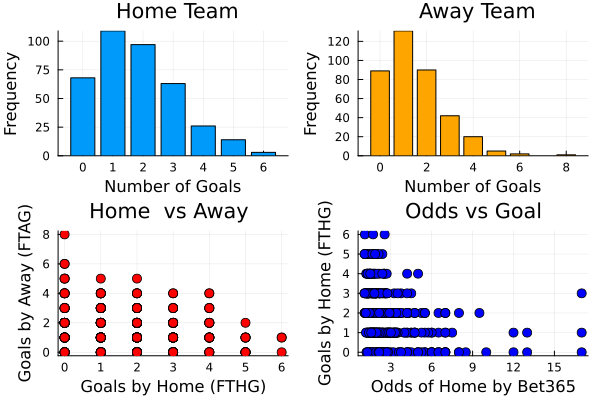

In [15]:
# Create side-by-side bar plots
p1 = bar(fthg_counts.value, fthg_counts.count, title=" Home Team"
            , xlabel="Number of Goals", ylabel="Frequency", legend=false)
p2 = bar(ftag_counts.value, ftag_counts.count, title=" Away Team"
             , xlabel="Number of Goals", ylabel="Frequency", legend=false
             , colour = "orange")

# Create a scatter plot
p3 = scatter(
        df.FTHG, df.FTAG,
        title = "Home  vs Away ",
        xlabel = "Goals by Home (FTHG)",
        ylabel = "Goals by Away (FTAG)",
        legend = false,
        markersize = 5,
        colour = "red"
    )

p4 = scatter(
        df.B365H, df.FTHG,
        title="Odds vs Goal",
        xlabel="Odds of Home by Bet365",
        ylabel="Goals by Home (FTHG)",
        legend=false,
        markersize=5,
        color="blue"
    )

# Display the plots in a 2x2 layout
plot(p1, p2, p3, p4, layout=(2, 2))

In [16]:
# Calculate the correlation between B365H and FTHG
correlation_value = cor(df.B365H, df.FTHG)
println("Correlation between Bet365 Home Odds and Home Goals: ", correlation_value)

Correlation between Bet365 Home Odds and Home Goals: -0.3162673821156749


# Poisson Regression in the Context of Goal Scored by Home Team and Bet365 Odds

Poisson regression is a type of generalised linear model (GLM) designed for modelling count data and rates of occurrence of events. The model assumes that the response variable $ Y $ follows a Poisson distribution, characterised by the probability mass function:
$$
P(Y = k) = \frac{\lambda^k e^{-\lambda}}{k!}, \quad k = 0, 1, 2, \dots
$$
where $ \lambda $ is the expected value (mean) of $ Y $ and also its variance. Poisson regression is particularly suited for situations where the outcome variable represents counts or frequencies.

In the context of football, the number of goals scored by the home team (FTHG) in a match can be modelled using Poisson regression. The Bet365 odds for the home team ($ X $, B365H) serve as a predictor variable. The regression model establishes a relationship between the predictor and the expected count of goals ($ \lambda $).

The mathematical formulation of the Poisson regression model is:

$$
\log(\lambda) = \beta_0 + \beta_1 X
$$

where:

- $ \lambda $ is the expected count of goals (\( \mathbb{E}[Y] \)).

- $ \beta_0 $ is the intercept, representing the baseline log-rate of goals when \( X \) (B365H odds) is zero.

- $ \beta_1 $ quantifies the change in the log-rate of goals for a unit change in \( X \).

The logarithmic link function $ \log(\lambda) $ ensures that the predicted count remains non-negative. For example, if $ \beta_1 $ is negative, it suggests that lower odds (better predicted chances of a home win) are associated with a higher expected number of goals scored by the home team.

By applying Poisson regression, analysts can explore how betting market expectations, represented by B365H odds, align with or influence actual match outcomes, such as goal counts. This model provides a structured approach to uncovering the relationships between event counts and predictor variables in a football context.

In [17]:
modl = fit(@formula(FTHG~B365H),df,PoissonRegression())

Model Class: Poisson Regression
Likelihood Mode: Poison
Link Function: Log
Computing Method: Optimization
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      z  Pr(>|z|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)   1.03728    0.0754994  13.74    <1e-42   0.889305   1.18526
B365H        -0.173252   0.0274976  -6.30    <1e-09  -0.227146  -0.119358
─────────────────────────────────────────────────────────────────────────


In [18]:
b = coef(modl)

2-element Vector{Float64}:
  1.0372808760079697
 -0.17325191704402648

In [19]:
x0 = [1, 3 , 6]
lambda_hat = exp.(b[1] .+ b[2]*x0)

3-element Vector{Float64}:
 2.372700976965593
 1.6778699882791348
 0.9977718597417706

In [20]:
# Calculate the CDF for each Poisson distribution at k = 3
cdf_values = [cdf(Poisson(λ), 3) for λ in lambda_hat]

prob_more_3_goals = 1 .- cdf_values

println("Prob that Home Team will score more tha 3 goals: ", prob_more_3_goals)

Prob that Home Team will score more tha 3 goals: [0.2155910021981431, 0.0899071958659835, 0.0188518466602855]


In [21]:
res = DataFrame(
    B365H_Odds = x0,
    lambda_hat = lambda_hat,
    prob_more_3_goals = prob_more_3_goals
)

println(res)


3×3 DataFrame
 Row │ B365H_Odds  lambda_hat  prob_more_3_goals 
     │ Int64       Float64     Float64           
─────┼───────────────────────────────────────────
   1 │          1    2.3727            0.215591
   2 │          3    1.67787           0.0899072
   3 │          6    0.997772          0.0188518


In [22]:
FTHG_hat= predict(modl,df)
R2_mod1 = cor(FTHG_hat,df.FTHG)^2

0.1457371388225332

In [23]:
modl2 = fit(@formula(FTHG~B365H+B365A),df,PoissonRegression())

Model Class: Poisson Regression
Likelihood Mode: Poison
Link Function: Log
Computing Method: Optimization
─────────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error      z  Pr(>|z|)    Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)   0.78843    0.115006     6.86    <1e-11   0.563023     1.01384
B365H        -0.128494   0.0300981   -4.27    <1e-04  -0.187485    -0.0695024
B365A         0.0265285  0.00937552   2.83    0.0047   0.00815284   0.0449042
─────────────────────────────────────────────────────────────────────────────


In [24]:
FTHG_hat= predict(modl2,df)
R2_mod2 = cor(FTHG_hat,df.FTHG)^2

0.1584919687523394

In [25]:
modl3 = fit(@formula(FTHG~B365H+HST),df,PoissonRegression())

Model Class: Poisson Regression
Likelihood Mode: Poison
Link Function: Log
Computing Method: Optimization
────────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error      z  Pr(>|z|)   Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)   0.063115    0.133226    0.47    0.6357  -0.198003    0.324233
B365H        -0.0755733   0.0270325  -2.80    0.0052  -0.128556   -0.0225906
HST           0.119134    0.0129982   9.17    <1e-19   0.0936581   0.14461
────────────────────────────────────────────────────────────────────────────


In [26]:
FTHG_hat= predict(modl3,df)
R2_mod3 = cor(FTHG_hat,df.FTHG)^2

0.3143933647981

### Bayesian Poisson Regression

In [27]:
modl4 = fit(@formula(FTHG~B365H+HST),df,PoissonRegression(),Prior_Ridge())

┌ Info: Found initial step size
└   ϵ = 0.00625
Sampling: 100%|█████████████████████████████████████████████████████████████| Time: 0:00:03


Formula: FTHG ~ 1 + B365H + HST
Link: CRRao.Identity(CRRao.Identity_Link)
Chain: Chains MCMC chain (1000×16×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 22.33 seconds
Compute duration  = 22.33 seconds
parameters        = λ, β[1], β[2], β[3]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   ess_per_sec 
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64       Float64 

           λ    0.1477    0.1192    0.0069   349.3954   349.3958    1.0110       15.6497
        β[1]    0.0347    0.0862    0.0043   418.1588   404.8596    1.0043       18.7297
        β[2]   -0.0685    0.0220    0.0011   428.2123   493.9941    1.0079       19.1800
        β[3

In [28]:
FTHG_hat = predict(modl4,df)
R2_mod4 = cor(FTHG_hat,df.FTHG)^2

0.3133798062366485

In [29]:
[R2_mod1,R2_mod2,R2_mod3,R2_mod4]

4-element Vector{Float64}:
 0.1457371388225332
 0.1584919687523394
 0.3143933647981
 0.3133798062366485

# **Wrap-Up**

In this session, we explored various aspects of data analysis and modelling using Julia, focusing on practical applications in statistics. Key highlights included:

1. **Data Manipulation**:
   - We learned to import and preprocess data using `CSV.jl` and `DataFrames.jl`.
   - Frequency calculations and creating visualisations like bar plots and scatter plots provided insights into the data.

2. **Statistical Measures**:
   - Calculated measures of central tendency (mean, median, mode) and dispersion (variance, standard deviation, range).
   - Computed quantiles to understand data distribution better.

3. **Modelling and Inference**:
   - Applied regression models, including Poisson regression, to establish relationships between variables such as home goals and Bet365 odds.
   - Discussed the mathematical basis of Poisson regression and how it is used to predict count data.

4. **Visualisation**:
   - Created meaningful visualisations like bar plots, histograms, and scatter plots to summarise and interpret data relationships.

5. **Correlation**:
   - Explored relationships between numerical variables using correlation, showcasing the connection between betting odds and match outcomes.

By leveraging Julia's robust ecosystem of packages, we efficiently performed complex data analysis and statistical modelling tasks. Julia’s high performance and ease of use make it an excellent choice for real-world data analysis, especially for large datasets and computationally intensive tasks.

Feel free to continue exploring Julia for more advanced statistical analyses, machine learning, and custom visualisations. Thank you for your attention, and happy coding! 🎉

# Q&A